# Modeling a Loyalty Program in E-commerce

As our Exploratory Data Analysis suggested, we can approach the modeling of a loyalty program in many ways, approaching different nuances. An efficient model for such use case should, ideally, take that into consideration in its design.

With that in mind, I will utilize an approach based on a Ensemble of Decision Trees. A model that can be used in such situation (that of a tree model that does not have a response variable) is the Isolation Forest model. This will be my main approach in this project.

In [1]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

In [2]:
# data processing and wrangling:
import pandas as pd
import numpy as np
import re
import unicodedata
import inflection
import warnings

# data and statistical visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, Image
import plotly.express as px
from scipy.special import erf
from scipy import stats
from sklearn.metrics import auc
import joblib

# outlier detection tools:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder


# metrics and evaluation:
import scikitplot as skplt
from sklearn.model_selection import train_test_split

# clustering tools:
import umap

# explainability tools:
import shap

# setting global parameters for visualizations:
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# 0. Utility Functions

In [3]:
def set_plot_settings():
    """Helper function to set standard plot settings for the jupyter notebook
    Note: these are hard-coded for my specific tastes
    """
    %matplotlib inline
    %pylab inline

    plt.rcParams["figure.figsize"] = [8, 6]
    plt.rcParams["figure.dpi"] = 120
    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.set_option("display.expand_frame_repr", False)
    sns.set_style("white")


def rotate_xticks(ax, rotation):
    """Helper function to rotate x-axis labels of a matplotlib-based plot

    Args:
        ax (axes.AxesSubplot): matplotlib subplot axis object that handles the figure
        rotation (int): degrees for which to rotate the axis x-ticks

    Returns:
        None

    """
    for item in ax.get_xticklabels():
        item.set_rotation(rotation)


def var_range(arr):
    """Function to handle pandas groupbys calculating range (max - min)"""
    return np.max(arr) - np.min(arr)


def make_aggregations(df):
    """Function to preprocess names of the columns"""
    new_columns = [f"{var}_{agg}" for var, agg in df.columns]
    df.columns = new_columns
    return df


def get_shap_contributions(df):
    """Helper function to build a shap contributions dataframe"""
    pdf = df.T

    contributions = []
    for client in pdf.columns:
        output = {"customer_id": client}

        output["max_positive_contribution"] = pdf[client].idxmax().replace("shap_", "")

        output["max_negative_contribution"] = pdf[client].idxmin().replace("shap_", "")
        contributions.append(output)

    results = pd.DataFrame(contributions)
    results = results.set_index("customer_id")
    return results


def create_segments(df):
    """Helper function to apply segments to the contributions dataframe"""
    results = []

    category_map = {
        "average_ticket": "High Average Ticket",
        "n_orders": "Large Number of Orders Made",
        "average_basket_diversity": "Large Basket Diversity",
        "average_basket_size": "Large Basket Size",
        "gross_revenue": "High Gross Revenue",
        "total_items": "Large Amount of Items Bought",
    }

    temp = df.copy()
    for idx, row in temp.iterrows():
        if row["is_eligible"] == 1:
            results.append(
                f"Eligible - {category_map[row['max_positive_contribution']]}"
            )
        else:
            results.append(f"Not Eligible")

    df["loyalty_segment"] = results
    return df

In [4]:
# setting the global variables for plotting:
set_plot_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. Loading and Inspecting the Data

In [5]:
# loading the raw dataset:
df = pd.read_parquet("../data/processed/tb_customer.parquet")

In [6]:
# setting the customer_id as the index:
df = df.set_index("customer_id")

# fixing the data types:
df.loc[:, "first_purchase_date"] = pd.to_datetime(df["first_purchase_date"])

In [7]:
# visualizing the dataset:
df.head()

,customer_country,first_purchase_date,is_foreign,account_age_days,recency,n_orders,gross_revenue,total_cancelled,frequency,monetary_value,...,total_discounts_received,total_paid_fees,total_paid_manual,total_paid_postage,total_paid_returned,total_paid_sale,total_units_cancelled,total_units_free,total_units_returned,total_units_sale
customer_id,,,,,,,,,,,,,,,,,,,,,
12940,united kingdom,2017-09-11,False,88,47,4,950.79,37.25,0.13,913.54,...,0.00,0.00,0.00,0.00,0.00,5.45,5.00,200.00,0.00,1.00
13285,united kingdom,2017-02-20,False,291,24,4,2709.12,0.00,0.13,2709.12,...,0.00,0.00,0.00,0.00,0.00,95.70,0.00,958.00,0.00,46.00
13623,united kingdom,2017-02-13,False,298,31,7,823.12,75.34,0.23,747.78,...,0.00,0.00,43.80,0.00,0.00,198.90,8.00,71.00,0.00,22.00
13832,united kingdom,2017-11-18,False,20,18,2,63.45,11.25,0.07,52.20,...,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00
14450,united kingdom,2017-01-21,False,321,181,3,483.25,0.00,0.10,483.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,104.00,0.00,0.00


In [8]:
# columns and data integrity:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5373 entries, 12940 to 19248
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customer_country                         5373 non-null   object        
 1   first_purchase_date                      5373 non-null   datetime64[ns]
 2   is_foreign                               5373 non-null   bool          
 3   account_age_days                         5373 non-null   int32         
 4   recency                                  5373 non-null   int32         
 5   n_orders                                 5373 non-null   int64         
 6   gross_revenue                            5373 non-null   float64       
 7   total_cancelled                          5373 non-null   float64       
 8   frequency                                5373 non-null   float64       
 9   monetary_value                      

The task of customer segmentation is very general. There are many ways we can segment customers. These can be identified in respect to demographics, purchasing habits, et cetera. The problem we have in hand here is to devise a data-driven Loyalty Program. There is a lot of freedom in developing such criteria and, with that, I will explain my take on this problem. 

First we need to understand what are the main drives in establishing a loyalty program in an E-commerce setting.

A Loyalty Program, in general, has one or more of the following objectives:

1. **Increasing customer's Lifetime Value**: Fidelity programs generate ways of making customers engage more with a brand, product or service, thus increasing the chances of such customer spending more money with a company's offerrings. Think about how much more likely you are to buy that pizza if you get a smaller one as an extra for being a loyal customer.

2. **Reducing Churn**: it is generally more expensive to acquire a customer than it is to retain one. Companies of all segments devise strategies to keep customers in the customer base and tend to avoid losing customers, except cases where it is not beneficial or costs more to maintain a customer than it is to find a new one. In E-commerce settings, this is also valid. Loyalty Programs also have as an objective increasing a customer's expectancy.

In our case, we can frame our problem into achieving higher CLV and a good approach would be to identify *exceptional customers* and use them as a "reference" to measure potential. My take here is to translate this task of finding *exceptional* customers to that of an anomaly detection framework that can take multivariate behavior (the many ways a customer might be exceptional) into consideration. 

For that, I will use a model called **Isolation Forest**, which is a ensemble model based on Extremely Randomized Trees that utilizes the recursive behavior of decision tree constructs to generate a proxy for identifying cases of anomalies using the *size of the decision paths* in the trees. Samples that are separated in shorter paths are more likely to be anomalies and stand out in the tree splitting mechanism.

This situation is good for our use case, since it allows us not only to identify "exceptional" customers, but also assign a "degre" or "score" to customers that aren't but that could be worked on.

# 3. Model Design

In order to make the results of an Isolation Forest more meaningful, we will adapt it to our needs, implementing a a new `predict_proba` method and adapting the `predict` method to a new, more reasonable scale. This way, the model feels like a regular classifier from an user perspective and allows to compare customer score more precisely.

In [9]:
# dependencies for custom model:
class LoyaltyScorer(IsolationForest):
    """Wraps the IsolationForest model from Sklearn with added features

    Notes on Features added:

    1. Implemented a method called transform_decisions that applies a linearization to the
       anomaly scores produced by the Isolation Forest. This puts them into the (0, 1) range.

    2. Implemented a predict_proba method that matches the anomaly scores to a distribution scaled to (0, 1)

    Parameters
    ----------
        Exactly the same as the Isolation Forest algorithm from sklearn.ensemble.IsolationForest
        - Please refer to the original algorithm's documentation
    """

    def __init__(
        self,
        n_estimators=100,
        max_samples="auto",
        contamination=0.2,
        max_features=1.0,
        bootstrap=False,
        n_jobs=1,
        random_state=None,
        verbose=0,
    ):

        super().__init__(
            contamination=contamination,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            bootstrap=bootstrap,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
        )

    def fit_scaler(self, X):
        """Stores the Average decision score from the shifted in order to perform different scoring operations

        Parameters
        ----------

        X : numpy array of shape (n_samples, 1) containing the samples for prediction

        """
        # shifting the decision function results:
        decisions = self.decision_function(X)

        decisions_shifted = (decisions.max() - decisions).ravel()

        # storing the parameters
        self.decision_param = decisions.max()
        self.lambda_param = np.mean(
            decisions_shifted
        )  # lambda parameter for fitting the exponential distribution
        self.linear_scaler = MinMaxScaler().fit(
            decisions_shifted.reshape(-1, 1)
        )  # for linear scoring
        self.mu = np.mean(decisions_shifted)  # mean for mu parameter
        self.sigma = np.std(decisions_shifted)  # standard deviation for sigma parameter

    def transform_decisions(self, decisions, behavior="exp"):
        """Transposes decision function such that outliers have higher values

        Parameters
        ----------

        decisions : numpy array of shape (n_samples, 1) containing the decision function results of the model

        Returns
        ---------
        scores : numpy array of the same shape containing the transformed scores

        """
        decisions_shifted = (self.decision_param - decisions).ravel()

        if behavior == "unifying":
            pre_erf_score = (decisions_shifted - self.mu) / (self.sigma * np.sqrt(2))

            scores = erf(pre_erf_score).clip(0, 1)

        elif behavior == "exp":
            scores = stats.expon.cdf(x=decisions_shifted, scale=self.lambda_param)

        else:
            scores = (
                self.linear_scaler.transform(decisions_shifted.reshape(-1, 1))
                .ravel()
                .clip(0, 1)
            )

        return scores

    def predict_proba(self, X, behavior="exp"):
        """Predict the probability of a sample being outlier.

        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The input samples

        behavior : string denoting what kind of scoring behavior
                   - 'linear': performs min-max scaling (0, 1)
                   - 'exp': performs exponential cdf scaling (0, 1)
                   - 'unifying': performs gaussian scaling based on Unifying Scores paper (0, 1)

        Returns
        -------
        outlier_probability : numpy array of shape (n_samples,)
            For each observation, tells whether or not
            it should be considered as an outlier according to the
            fitted model. Return the outlier probability, ranging
            in [0,1].
        """
        decisions = self.decision_function(X)
        scores = self.transform_decisions(decisions, behavior)
        outlier_probability = np.zeros([X.shape[0], 2])
        outlier_probability[:, 1] = scores
        outlier_probability[:, 0] = 1 - outlier_probability[:, 1]
        return outlier_probability

    def predict(self, X):
        """Classifies input samples based on threshold from Isolation Forest decision function (1 if < 0)

        Parameters
        ----------
        X: numpy array of shape (n_samples, n_features)
           The input samples

        Returns
        --------
        predicted_class : the class predicted
                          0 -> inliner
                          1 -> outlier
        """
        predictions = np.zeros(X.shape[0], dtype=int)
        predictions[self.decision_function(X) < 0] = 1
        return predictions

# 4. Model Experiments

## 4.1 Selecting Features
The features I will use for the model itself correspond to those that are illustrate behaviors of interest for a loyalty program. These are listed below.

In [10]:
model_features = [
    "is_considered_reseller",
    "gross_revenue",
    "n_orders",
    "average_ticket",
    "average_basket_size",
    "average_basket_diversity",
    "total_items",
]

# extracting the features:
df_features = df[model_features].copy()

## 4.2 Splitting the Audience
Since the customers that we considered resellers are by default a different kind of customer, we will not consider them into the model. Due to their status as a commercial partner, they will already be included in the program, without needing to be categorized by the model.

In [11]:
# splitting the dataset into regular customers and resellers:
X_regular = (
    df_features[df_features.is_considered_reseller != 1]
    .copy()
    .drop(columns=["is_considered_reseller"])
)

X_reseller = (
    df_features[df_features.is_considered_reseller == 1]
    .copy()
    .drop(columns=["is_considered_reseller"])
)

## 4.3 Baseline Model
Before we go by tunning any parameter, we need to assess the preliminary results from the perspectiva of a baseline model.

In [12]:
# establishing the base model (auto)
base_model = LoyaltyScorer(
    max_features=len(X_regular.columns),  # we need to consider all variables at first
    random_state=42,
    verbose=False,
    bootstrap=False,
)

In [13]:
# fitting the model:
base_model.fit(X_regular)
base_model.fit_scaler(X_regular)

In [14]:
# Running the model predictions on the dataset for further analysis
X_regular["anomaly_score"] = base_model.decision_function(X_regular.values)

X_regular["is_eligible"] = base_model.predict(
    X_regular.drop(columns=["anomaly_score"]).values
)

X_regular["loyalty_score"] = base_model.predict_proba(
    X_regular.drop(columns=["anomaly_score", "is_eligible"]).values
)[:, 1]

In [15]:
# resulting columns:
X_regular.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5104 entries, 12940 to 19235
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gross_revenue             5104 non-null   float64
 1   n_orders                  5104 non-null   int64  
 2   average_ticket            5104 non-null   float64
 3   average_basket_size       5104 non-null   float64
 4   average_basket_diversity  5104 non-null   float64
 5   total_items               5104 non-null   int32  
 6   anomaly_score             5104 non-null   float64
 7   is_eligible               5104 non-null   int64  
 8   loyalty_score             5104 non-null   float64
dtypes: float64(6), int32(1), int64(2)
memory usage: 378.8 KB


In [16]:
# sorting the data:
X_regular = X_regular.sort_index()
X_reseller = X_reseller.sort_index()

In [17]:
embedding_features = [
    "account_age_days",
    "average_basket_diversity",
    "average_basket_size",
    "average_ticket",
    "average_time_between_purchases",
    "average_time_to_next_bank_holiday",
    "average_time_to_next_commercial_holiday",
    "customer_country",
    "day_of_month_most_active",
    "day_of_week_most_active",
    "frequency",
    "gross_revenue",
    "is_considered_reseller",
    "is_foreign",
    "monetary_value",
    "month_most_active",
    "n_orders",
    "recency",
    "total_cancelled",
    "total_cancelled_items",
    "total_discounts_received",
    "total_free_items",
    "total_items",
    "total_paid_fees",
    "total_paid_manual",
    "total_paid_postage",
    "total_paid_returned",
    "total_paid_sale",
    "total_returned_items",
    "total_sale_items",
    "total_units_cancelled",
    "total_units_free",
    "total_units_returned",
    "total_units_sale",
    "week_most_active",
]

X_pre_emb = df[embedding_features].copy().sort_index()

In [18]:
# filling Null values:
X_pre_emb.loc[:, "average_time_between_purchases"] = X_pre_emb[
    "average_time_between_purchases"
].fillna(999)

In [19]:
# creating dummy variable for country column:
encoder = LabelEncoder()
encoder.fit(X_pre_emb["customer_country"])
X_pre_emb["country_encoded"] = encoder.transform(X_pre_emb["customer_country"])
X_pre_emb.loc[:, "is_foreign"] = X_pre_emb["is_foreign"].astype(int)
X_pre_emb.loc[:, "is_considered_reseller"] = X_pre_emb["is_considered_reseller"].astype(
    int
)

In [20]:
# dropping leftover columns:
X_pre_emb = X_pre_emb.drop(columns=["customer_country"])

# 5. Representing Customers in low-dimensional spaces
In order to make intuitive sense of how customers are similar in terms of their many features (and thus behaviors), we need to visualize them somehow. We will approach this by leveraging a dimensionality reduction technique called UMAP. UMAP is similar to tSNE, as it generates embeddings from high-dimensional data onto a low-dimensional space, but it is vastly superior in terms of performance and also representations. 

In [21]:
# generating an embedding for the customers at a lower dimensional projection
umapper = umap.UMAP(random_state=42)

# generating the projections
embedding = umapper.fit_transform(X_pre_emb.values)

# generating a datafame with the embedding:
df_emb = pd.DataFrame(
    data={"x": embedding[:, 0], "y": embedding[:, 1]},
    index=X_pre_emb.index,
)

# joining onto the projection:
df_emb_full = pd.merge(
    df_emb,
    X_regular[["is_eligible", "loyalty_score", "anomaly_score"]],
    how="left",
    left_index=True,
    right_index=True,
)

In [24]:
# fillinng the nulls:
df_emb_full.loc[:, "is_eligible"] = df_emb_full["is_eligible"].fillna(1)
df_emb_full.loc[:, "loyalty_score"] = df_emb_full["loyalty_score"].fillna(1)
df_emb_full.loc[:, "anomaly_score"] = df_emb_full["anomaly_score"].fillna(99)

In [25]:
# converting to a category:
df_emb_full.loc[:, "is_eligible"] = df_emb_full["is_eligible"].apply(lambda x: bool(x))

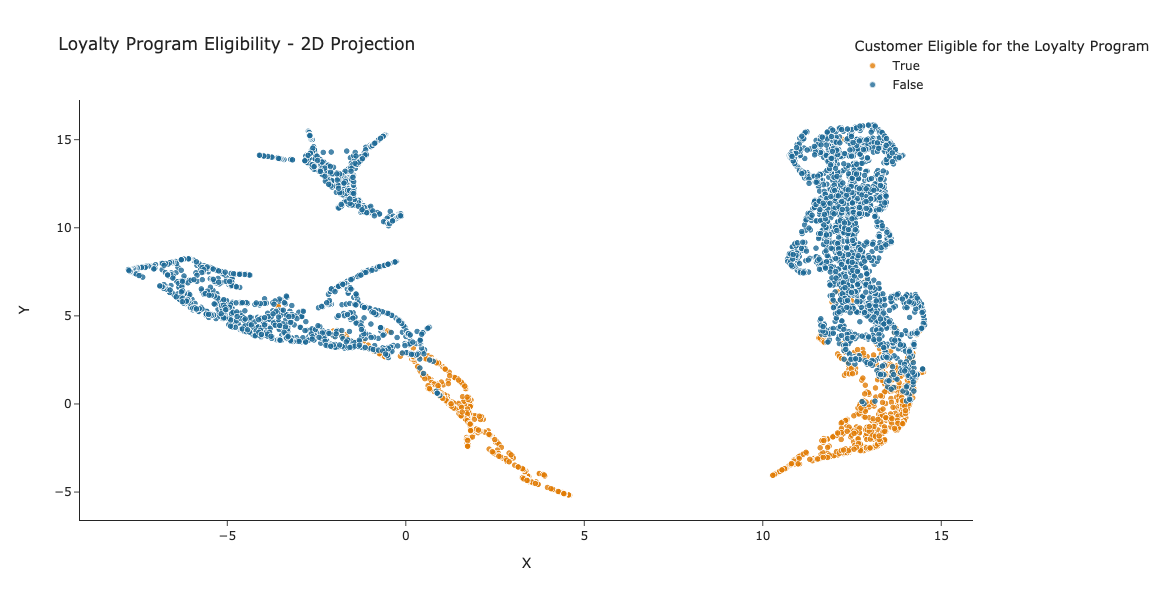

In [41]:
emb_cols = {
    "loyalty_score": "Loyalty Score",
    "is_eligible": "Customer Eligible for the Loyalty Program",
    "x": "X",
    "y": "Y",
}

color_binary_order = ["rgb(225, 124, 5)", "rgb(29, 105, 150)"]

fig = px.scatter(
    df_emb_full,
    x="x",
    y="y",
    template="simple_white",
    opacity=0.8,
    color="is_eligible",
    labels=emb_cols,
    title="Loyalty Program Eligibility - 2D Projection",
    # render_mode="svg",
    color_discrete_sequence=color_binary_order,
    height=600,
    #     width=900,
)


fig.update_layout(
    legend=dict(orientation="v", yanchor="bottom", xanchor="right", y=1, x=1.2)
)

fig.update_traces(mode="markers", marker_line_width=0.7, marker_line_color="white")

# fig.write_image("../reports/figures/loyalty_program_eligibility.svg", engine="kaleido")

fig.show()

The visual, low-dimensional projection of our space suggests two distinct groups that are quite noticeable. On both cases, the customers identified by our model are projected on the lower segments of the embedding representation in the 2D space (orange points on the scatterplot). This suggests that, on average, our loyal customers are similar to each other (which is a good characteristic to explore), even if they are assigned eligibility for different reasons.

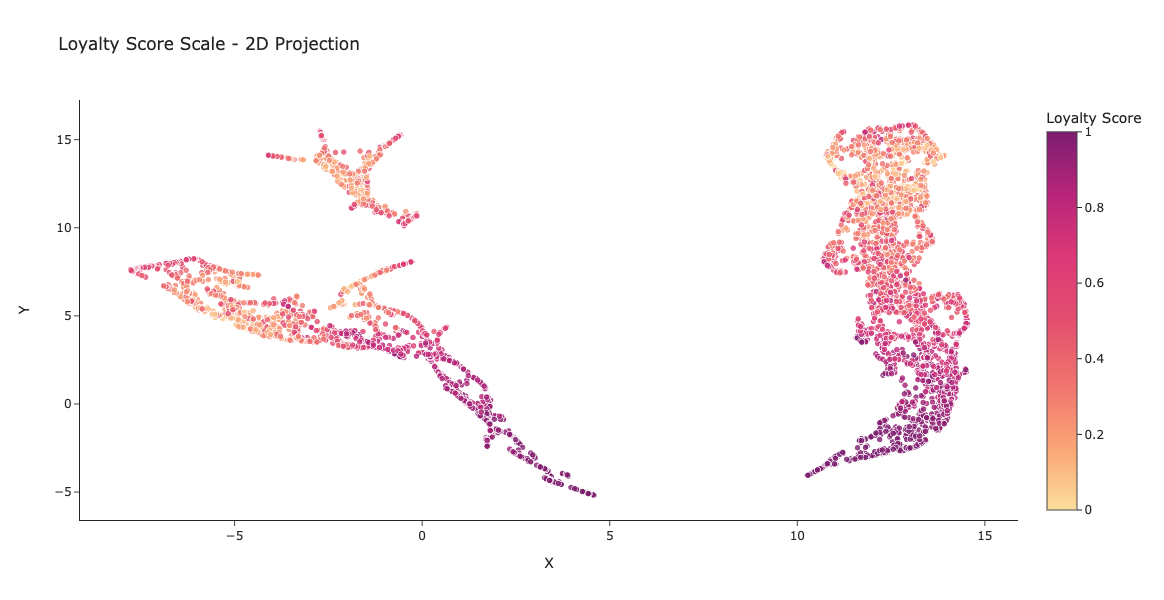

In [40]:
emb_cols = {
    "loyalty_score": "Loyalty Score",
    "is_eligible": "Customer Eligible for the Loyalty Program",
    "x": "X",
    "y": "Y",
}

color_binary_order = ["rgb(225, 124, 5)", "rgb(29, 105, 150)"]

fig = px.scatter(
    df_emb_full,
    x="x",
    y="y",
    template="simple_white",
    opacity=0.8,
    color="loyalty_score",
    labels=emb_cols,
    title="Loyalty Score Scale - 2D Projection",
    color_continuous_scale="Sunsetdark",
    #     render_mode="svg",
    height=600,
    #     width=900,
)


fig.update_layout(
    legend=dict(orientation="v", yanchor="bottom", xanchor="right", y=1, x=1)
)

fig.update_traces(mode="markers", marker_line_width=0.7, marker_line_color="white")

# fig.write_image("../reports/figures/oyalty_score_scale.svg", engine="kaleido")

fig.show()

In [42]:
# characterizing the customers eligible for thee loyalty program:
df_emb_full.groupby("is_eligible")[["loyalty_score"]].count()

,loyalty_score
is_eligible,
False,4083
True,1290


In [43]:
# the model identified about 24% of customers as eligible for the loyalty program
df_emb_full.is_eligible.value_counts(normalize=True)

False   0.76
True    0.24
Name: is_eligible, dtype: float64

# 6. Customer Attributes
Given we have an initial description of the model prescription for the customers that would be eligible for the loyalty program, we will follow up by analyzing relevant statistics about them.

In [44]:
# joining features into the embedding dataframe:
df_full = pd.merge(
    df_emb_full,
    X_regular.drop(columns=["is_eligible", "loyalty_score", "anomaly_score"]),
    left_index=True,
    right_index=True,
    how="inner",
)

In [45]:
# features to extract statistics from:
stat_features = [
    "gross_revenue",
    "n_orders",
    "average_ticket",
    "average_basket_size",
    "average_basket_diversity",
    "total_items",
]

In [46]:
# calculating statistics over each group:
df_full.groupby("is_eligible")[stat_features].agg(
    [np.mean, np.median, np.min, np.max]
).T

is_eligible                       False    True 
gross_revenue            mean    692.95  2808.40
                         median  482.52  2609.10
                         amin      0.00     0.00
                         amax   3637.97  7284.20
n_orders                 mean      2.75     5.60
                         median    2.00     1.00
                         amin      1.00     1.00
                         amax     13.00    39.00
average_ticket           mean    270.16  1338.02
                         median  223.06  1046.79
                         amin      0.00     0.00
                         amax   1584.36  5664.89
average_basket_size      mean    141.30   501.94
                         median  117.00   394.00
                         amin      1.00     1.00
                         amax    666.00 12540.00
average_basket_diversity mean     19.21   107.09
                         median   14.33    54.00
                         amin      1.00     1.00
                         amax    128.00   598.00
total_items              mean    382.71  1426.16
                         median  240.00  1123.00
                         amin      1.00     1.00
                         amax   2266.00 12540.00

We can see that, on average, customers eligible for the loyalty program are more prone to display wanted behaviors, such as high gross revenue and large basket sizes. There are still some that seem off, however, such as customers with `0` gross revenue. This behavior can be tuned such that it is avoid with better parameters for our Isolation Forest model.

# 7. Interpreting Model Results
In order to make sense of how the model assigned an outlier score and corresponding label to each customer, we will analyze the Shapley Values related to every prediction. We will use this to further segment the clients and give them "reasons" to be eligible for the loyalty program, which is an added dimension to the model itself.

In [47]:
# extracting the results to explain:
X_explain = X_regular.drop(
    columns=["is_eligible", "anomaly_score", "loyalty_score"]
).copy()

In [48]:
# instantiating the shap environment
shap.initjs()

In [49]:
# calculating shap values:
explainer = shap.TreeExplainer(base_model, data=X_explain)
shap_values = explainer.shap_values(X_explain, check_additivity=True)

 97%|=================== | 4971/5104 [00:21<00:00]       

In [50]:
# let's attribute th values shap values for each column to all records:
df_shap = pd.DataFrame(
    shap_values,
    columns=[f"shap_{col}" for col in X_explain.columns],
    index=X_explain.index,
)

# extracting the main contributions:
df_shap_contributions = get_shap_contributions(df_shap)

In [51]:
# adding the eligibility handle to the contributions dataframe:
df_shap_contributions = pd.merge(
    df_shap_contributions,
    X_regular[["is_eligible", "loyalty_score"]],
    how="inner",
    left_index=True,
    right_index=True,
)

In [52]:
# helper column for counts on group by operations:
df_shap_contributions["n_clients"] = 1

In [53]:
# let's visualize how many top contributions we have:s
contrib_counts = (
    df_shap_contributions.groupby(["is_eligible", "max_positive_contribution"])[
        ["n_clients"]
    ]
    .count()
    .reset_index()
)

# filter for only the eligible customers:
contrib_counts = contrib_counts[contrib_counts.is_eligible == 1].sort_values(
    by="n_clients", ascending=False
)

In [54]:
# results become:
contrib_counts

,is_eligible,max_positive_contribution,n_clients
6,1,average_basket_diversity,370
10,1,n_orders,319
11,1,total_items,202
8,1,average_ticket,87
9,1,gross_revenue,27
7,1,average_basket_size,16


It seems that the main reason amongst non-reseller (regular) customers to be considered eligible is related to the number of orders and basket diversity. This is a good behavior to develop in a customer base and shows potential in such clients. 

In [55]:
# let's add these "reasons" as a second-step segmentation to the model results:
df_shap_contributions = create_segments(df_shap_contributions)

In [56]:
# adding the results back onto the embedding:
df_results = pd.merge(
    df_full, df_shap_contributions, how="inner", left_index=True, right_index=True
)

In [225]:
# adding a color scale map:
color_scale_order = [
    "Not Eligible",
    "Eligible - Large Number of Orders Made",
    "Eligible - Large Basket Diversity",
    "Eligible - High Average Ticket",
    "Eligible - Large Basket Size",
    "Eligible - High Gross Revenue",
    "Eligible - Large Amount of Items Bought",
]

color_seq = ["#003f5c", "#444e86", "#955196", "#dd5182", "#ff6e54", "#ffa600"]

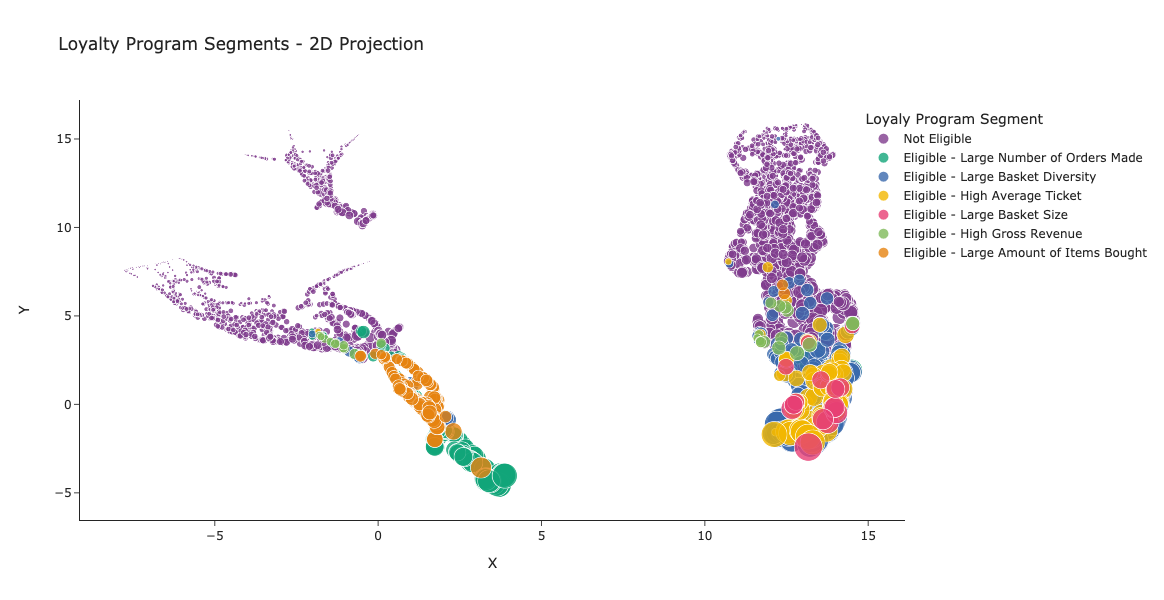

In [228]:
emb_cols = {
    "loyalty_score": "Loyalty Score",
    "is_eligible": "Customer Eligible for the Loyalty Program",
    "x": "X",
    "y": "Y",
    "loyalty_segment": "Loyaly Program Segment",
}

fig = px.scatter(
    df_results,
    x="x",
    y="y",
    template="simple_white",
    opacity=0.8,
    color="loyalty_segment",
    labels=emb_cols,
    size="gross_revenue",
    title="Loyalty Program Segments - 2D Projection",
    color_discrete_sequence=px.colors.qualitative.Bold,
    category_orders={"loyalty_segment": color_scale_order},
    #     render_mode="svg",
    height=600,
)


fig.update_layout(
    legend=dict(orientation="v", yanchor="bottom", xanchor="right", y=0.6, x=1.3)
)

# fig.write_image("../reports/figures/loyalty_program_segments.svg", engine="kaleido")

fig.show()

In [79]:
# mapping cluster labels:
cluster_label_map = dict(enumerate(list(color_scale_map.keys())))

# reverses the lookup:
cluster_label_map = {v: k for k, v in cluster_label_map.items()}

# inserting the cluster labels:
df_results["cluster_labels"] = df_results["loyalty_segment"].map(cluster_label_map)

# 8. Tunning the Model

Since this is inherently an unsupervised learning problem, the tunning of the model itself is done differently. It relies heavily on the business objectives and also on relevant metrics regarding the types of models used (measures of homogenuity, for example for KMeans models). 

In our case, we modeled the problem using an anomaly detection approach (and we have no labels), we will approach it from the business perspective.
One of the parameters in a Isolation Forest model is the `contamination` parameter. It essentially controls the proportion of samples that will be considered outliers (and, in our case, eligible for the loyalty program).

This is especially useful, because we can essentially specify the amount or proportion of customers we want to bring into the loyalty program. For this project, I will use a contamination parameter set to `auto`, as I want the model to tell me the proportion.

In [170]:
final_model = LoyaltyScorer(
    n_estimators=500,
    max_samples="auto",
    contamination=0.05,
    n_jobs=-1,
    max_features=len(X_explain.columns),
    random_state=42,
    verbose=True,
    bootstrap=False,
)

In [171]:
# fitting the final model:
final_model.fit(X_explain)
final_model.fit_scaler(X_explain)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.8s remaining:    3.9s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.8s finished


In [172]:
# instantiating the output dataset:
X_output = X_explain.copy()

In [173]:
# Running the model predictions on final output dataset:
X_output["anomaly_score"] = final_model.decision_function(X_output.values)

X_output["is_eligible"] = final_model.predict(
    X_output.drop(columns=["anomaly_score"]).values
)

X_output["loyalty_score"] = final_model.predict_proba(
    X_output.drop(columns=["anomaly_score", "is_eligible"]).values
)[:, 1]

In [174]:
# adding back the resellers:
X_reseller["anomaly_score"] = None
X_reseller["is_eligible"] = 1
X_reseller["loyalty_score"] = 1.0

X_final = pd.concat([X_output, X_reseller])

In [176]:
feature_cols = X_final.drop(
    columns=["anomaly_score", "is_eligible", "loyalty_score"]
).columns

score_cols = [col for col in X_final.columns if col not in feature_cols]

In [178]:
# let's generate the projection of users:
umap_final = umap.UMAP(random_state=42)

# generating the projections
embedding = umap_final.fit_transform(X_pre_emb.values)

# generating a datafame with the embedding:
df_emb = pd.DataFrame(
    data={"x": embedding[:, 0], "y": embedding[:, 1]},
    index=X_final.index,
)

# joining onto the projection:
df_emb_full = pd.merge(
    df_emb,
    X_final[["is_eligible", "loyalty_score", "anomaly_score"]],
    how="inner",
    left_index=True,
    right_index=True,
)

In [179]:
# converting to a category:
df_emb_full.loc[:, "is_eligible"] = df_emb_full["is_eligible"].apply(lambda x: bool(x))

In [180]:
# calculating shap values:
explainer = shap.TreeExplainer(
    base_model,
    data=X_final.drop(columns=["anomaly_score", "is_eligible", "loyalty_score"]),
)
shap_values = explainer.shap_values(
    X_final.drop(columns=["anomaly_score", "is_eligible", "loyalty_score"]),
    check_additivity=True,
)

 98%|===================| 5267/5373 [00:22<00:00]        

In [181]:
# let's attribute th values shap values for each column to all records:
df_shap = pd.DataFrame(
    shap_values,
    columns=[f"shap_{col}" for col in feature_cols],
    index=X_final.index,
)

# extracting the main contributions:
df_shap_contributions = get_shap_contributions(df_shap)

In [182]:
# adding the eligibility handle to the contributions dataframe:
df_shap_contributions = pd.merge(
    df_shap_contributions,
    X_final[score_cols],
    how="inner",
    left_index=True,
    right_index=True,
)

In [183]:
# let's add these "reasons" as a second-step segmentation to the model results:
df_shap_contributions = create_segments(df_shap_contributions)

In [185]:
# final dataset:
df_final = pd.merge(
    X_final,
    df_shap_contributions[["max_positive_contribution", "loyalty_segment"]],
    how="inner",
    left_index=True,
    right_index=True,
)

df_final = pd.merge(
    df_final,
    df_shap,
    how="inner",
    left_index=True,
    right_index=True,
)

df_final = pd.merge(
    df_final,
    df_emb_full[["x", "y"]],
    how="inner",
    left_index=True,
    right_index=True,
)

# 9. Characterizing the Final Results

In [189]:
# final proportion, with the resellers becomes:
df_final.is_eligible.value_counts(normalize=True) # about 10% of the customers

0   0.90
1   0.10
Name: is_eligible, dtype: float64

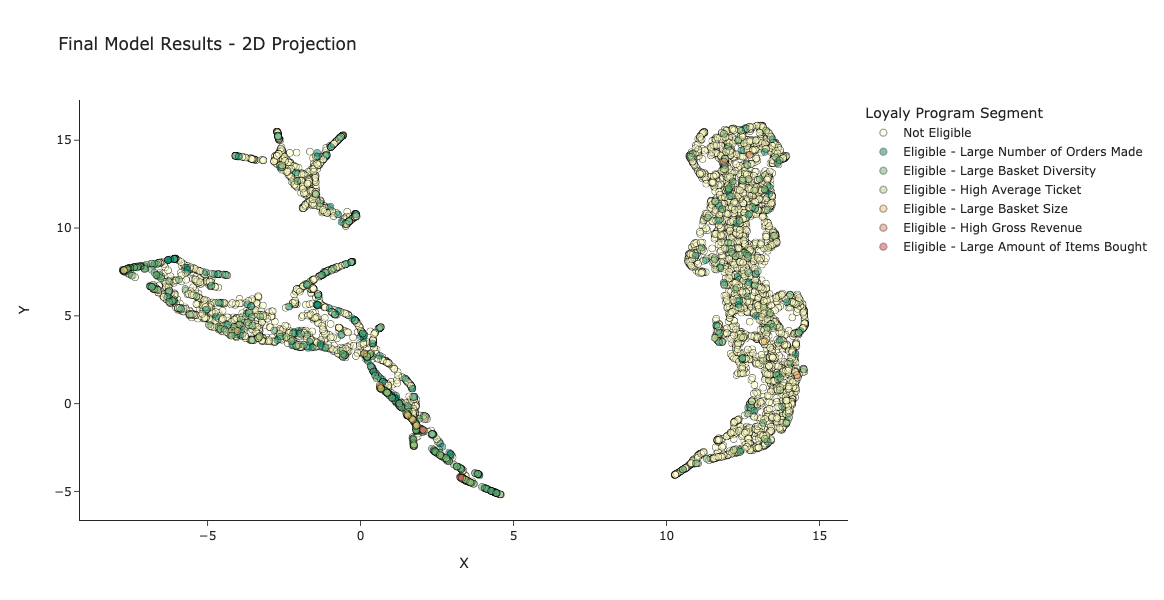

In [240]:
emb_cols = {
    "loyalty_score": "Loyalty Score",
    "is_eligible": "Customer Eligible for the Loyalty Program",
    "x": "X",
    "y": "Y",
    "loyalty_segment": "Loyaly Program Segment",
}

colors = ["#ffffc7", "#00876c", "#64ad73", "#afd17c", "#fbb862", "#ee7d4f", "#d43d51"]

fig = px.scatter(
    df_final,
    x="x",
    y="y",
    template="simple_white",
    opacity=0.5,
    color="loyalty_segment",
    labels=emb_cols,
    title="Final Model Results - 2D Projection",
    color_discrete_sequence=colors,
    category_orders={"loyalty_segment": color_scale_order},
    #     render_mode="svg",
    height=600,
)


fig.update_traces(
    mode="markers", marker_line_width=0.8, marker_line_color="black", marker_size=7
)


# fig.write_image(
#     "../reports/figures/final_model_results_projection.svg", engine="kaleido"
# )

fig.show()

Our new model displays a different behavior in its final form. The concentrations we saw before in certain parts of the embedding projection still exist, but to a lesser extent. We also see customers being assigned eligibility in different regions of the projection, which suggests that we have more customers being categorized by different "reasons". This behavior is beneficial since, with that, we can capture different kinds of behavior that are useful for a loyalty program instead of concentrating on a single, strong feature.

We also our total make-up of customers eligible for the loyalty program at aorund 10% including the resellers, which, for our purposes, is a good proportion. In the real world, we would circle results back with the business and product teams such as to find the optimum proportion of customers for the program (and thus tune the `contamination` parameter in the model).

# 10. Exporting Results

In [190]:
# saving the output:
df_final.to_parquet("../data/predict/model_results.parquet")

In [191]:
# saving the model:
joblib.dump(final_model, "../models/loyalty_program_model.joblib")

['../models/loyalty_program_model.joblib']

# 12. Conclusions

By framing the business problem of creating a Loyalty Program for an E-commerce website as an anomaly detection in this project, we were able to create a versatile model leveraring purely unsupervised learning techniques. We also utilized the fact that our chosen model (Isolation Forest) has a similar structure from that of Decision Tree and applied SHAP values as an interpretability tool to further segment the customers such as to assign them "reasons" for being eligible for the loyalty program.

Our final model displayed three desired behaviors:

1. It respected a previously defined threshold for the proportion of customers to take part into the Loyalty Program, something than a regular, density-based or distance based clustering model would not allow;
2. It does not rely on similarity between customers in the feature space, which helps us identify customers without needing to keep track of such spaces;
3. By leveraring the model's anomaly scores, we are able to generate loyalty "scores" that can be applied to the entire customer base and be used for priorization (ordering) tasks;